# Template Matching for Table Extraction

This Python Jupyter notebook presents some basic image processing techniques required for the extraction of objects from source images. 
It uses template matching and template rotation techniques to extract the weather tables from pages of the [Bozner Zeitung](https://digital.tessmann.it/tessmannDigital/Zeitungsarchiv/Jahresuebersicht/Zeitung/2;jsessionid=EDB74DD563DFEB1A966A78C0B39E0D5F).

The required libraries are imported. The versions of the tools used are put out.

In [1]:
from platform import python_version
import numpy as np
import cv2
import imutils
import matplotlib
import matplotlib.pyplot as plt 

In [2]:
print("Python Version: " + python_version())
print("Numpy Version: " + np.__version__)
print("OpenCV Version: " + cv2.__version__)
print("Imutils Version: " + imutils.__version__)
print("Matplotlib Version: " + matplotlib.__version__)

Python Version: 3.7.7
Numpy Version: 1.19.0
OpenCV Version: 4.3.0
Imutils Version: 0.5.3
Matplotlib Version: 3.2.2


The source image (**document**) containing the object to be matched and the matching **template** are loaded and plotted.

In [3]:
document = "newspaper_page.png"
template = "template.png"

img_rgb = cv2.imread(document)
img_rgb_copy = img_rgb.copy()
template = cv2.imread("template.png")

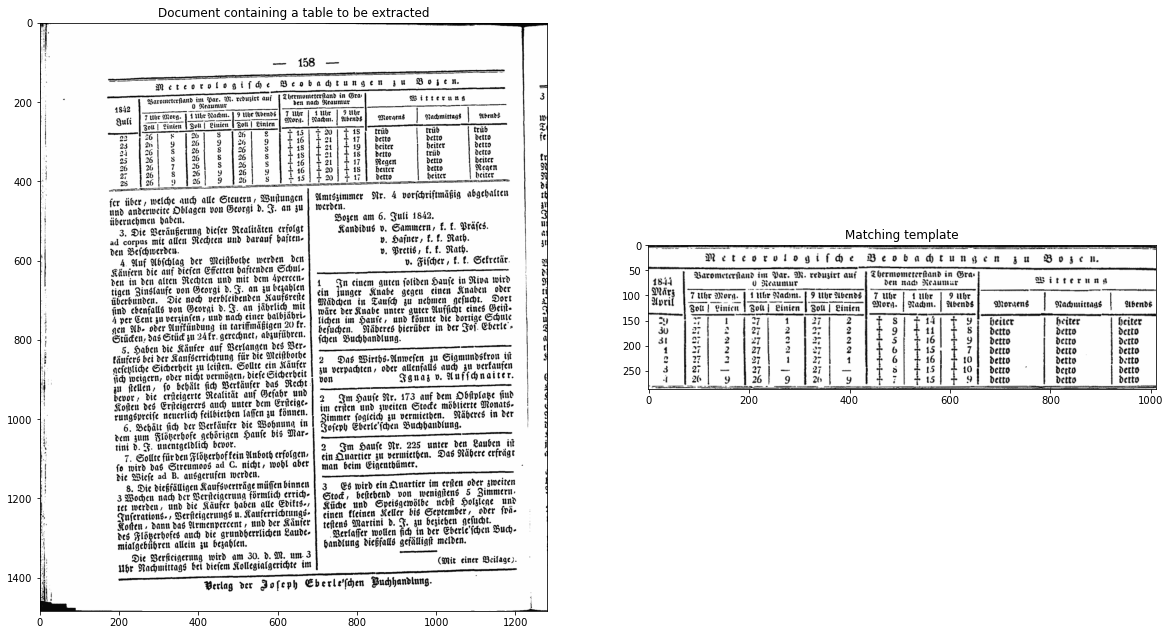

In [4]:
plt.figure(figsize = (20,16))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Document containing a table to be extracted")
plt.subplot(1,2,2)
plt.imshow(template)
plt.title("Matching template")
plt.show()

## Basic Matching Approach

The method described below follows the [Open-CV Template Matching Tutorial](https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html), where additional information can be found. In brief, the **matchTemplate()**-function returns an array representing the pointwise matching degree between source image and template.
The higher the individual value of an element in the array, the higher the degree of matching between source image and template in the immediate vicinity of that element.

In [5]:
matching_array = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)

The [**minMaxLoc()**](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gab473bf2eb6d14ff97e89b355dac20707)-function returns the global minimal and maximal values in an array, as well as their positions.

In [6]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matching_array)

Having found the location of the best matching point, one can use the template height and width to extract the matching object from the source image. 

In [7]:
template_height = template.shape[0]
template_width = template.shape[1]

In [8]:
top_left_corner = max_loc
bottom_right_corner = (top_left_corner[0] + template_width, top_left_corner[1] + template_height)

For visualization purposes, the matching object can be marked as a rectangle in the source image or can be cropped and visualized individually.

In [9]:
img_with_rectangle = cv2.rectangle(img_rgb, top_left_corner, bottom_right_corner, 255, 4)
cropped_matching_object = img_rgb_copy[top_left_corner[1] : top_left_corner[1] + \
                                       template_height, top_left_corner[0] : top_left_corner[0] + template_width]

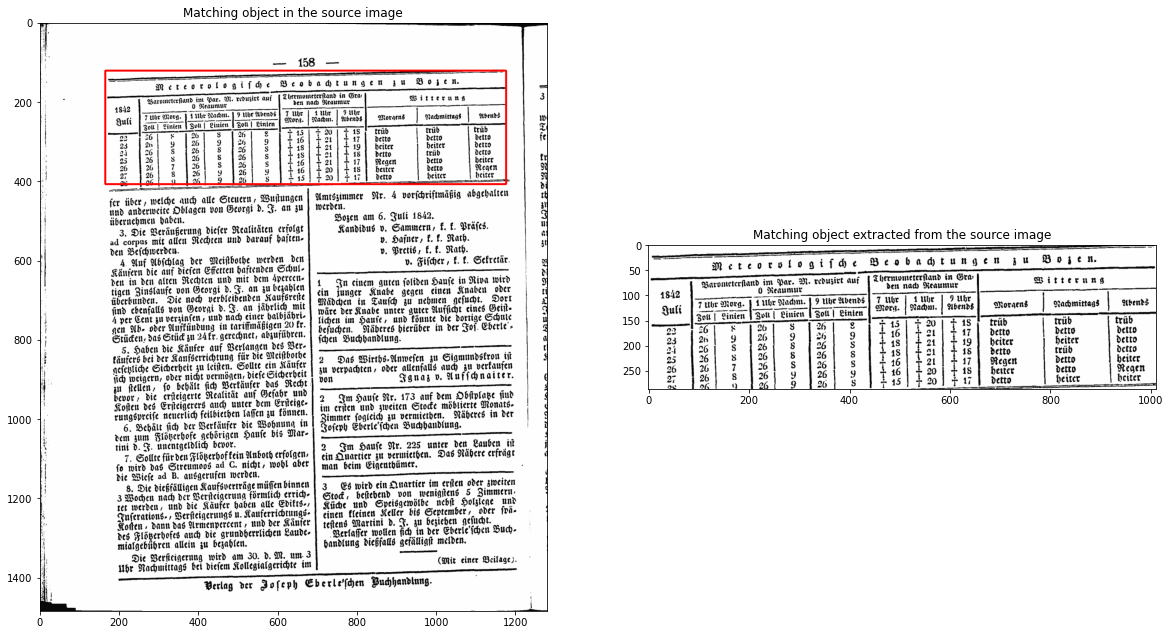

In [10]:
plt.figure(figsize = (20,16))
plt.subplot(1,2,1)
plt.imshow(img_with_rectangle)
plt.title("Matching object in the source image")
plt.subplot(1,2,2)
plt.imshow(cropped_matching_object)
plt.title("Matching object extracted from the source image")
plt.show()

## Matching Approach with Template Rotation

Due to the fact that source image and template display different rotation angles, template matching is not optimal. This problem can be solved using the **imutils.rotate()**-function in order to adjust rotation angles.

In [11]:
img_rgb = cv2.imread(document)
img_rgb_copy = img_rgb.copy()
template = cv2.imread("template.png")

In [12]:
rotated_1 = imutils.rotate(template, -2)
rotated_2 = imutils.rotate(template, -1)
rotated_3 = imutils.rotate(template, 0)
rotated_4 = imutils.rotate(template, 1)
rotated_5 = imutils.rotate(template, 2)

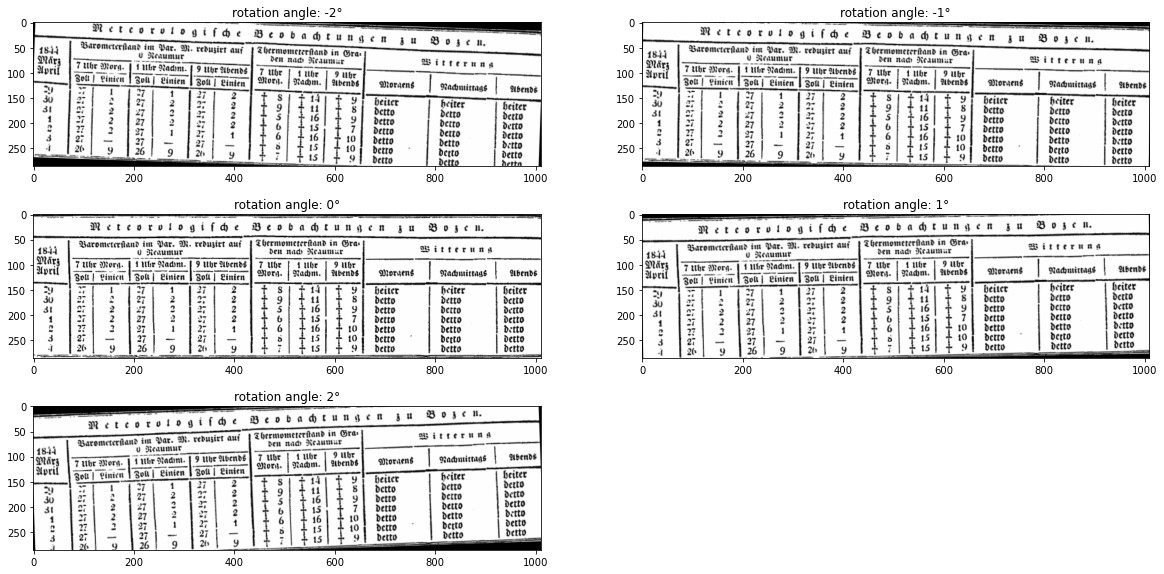

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
plt.imshow(rotated_1)
plt.title("rotation angle: -2°")
plt.subplot(3,2,2)
plt.imshow(rotated_2)
plt.title("rotation angle: -1°")
plt.subplot(3,2,3)
plt.imshow(rotated_3)
plt.title("rotation angle: 0°")
plt.subplot(3,2,4)
plt.imshow(rotated_4)
plt.title("rotation angle: 1°")
plt.subplot(3,2,5)
plt.imshow(rotated_5)
plt.title("rotation angle: 2°")
plt.show()

The optimal rotation angle for the matching can be found using an iterative approach. The template rotation angle is varied stepwise during the matching procedure in order to find the maximal array values for each angle. The highest of the maximal array values represents the best match.

In [14]:
# Rotation start, end and steps are defined
start_rot_angle = -2
end_rot_angle = 2
rot_step = 0.1

rotation = start_rot_angle

# max_val_prev variable is initialized
max_val_prev = -10

# the while-loop iterates over different rotation angles and saves the highest
# reached array value in the variable max_val_opt
while (rotation <= end_rot_angle):
    rotation = rotation + rot_step
    rotated = imutils.rotate(template, rotation) # <-- this is the rotated template
    matching_array = cv2.matchTemplate(img_rgb, rotated, cv2.TM_CCOEFF_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(matching_array)
    
    if max_val > max_val_prev:
        max_val_opt = max_val  
        max_loc_opt = max_loc
        rotation_opt = rotation
    else:
        pass  
    
    max_val_prev = max_val

The optimal matching location found this way can again be visualized as described above. By having extracted not only the optimal matching location, but also the optimal rotation angle, the rotation of the source image can be corrected accordingly.

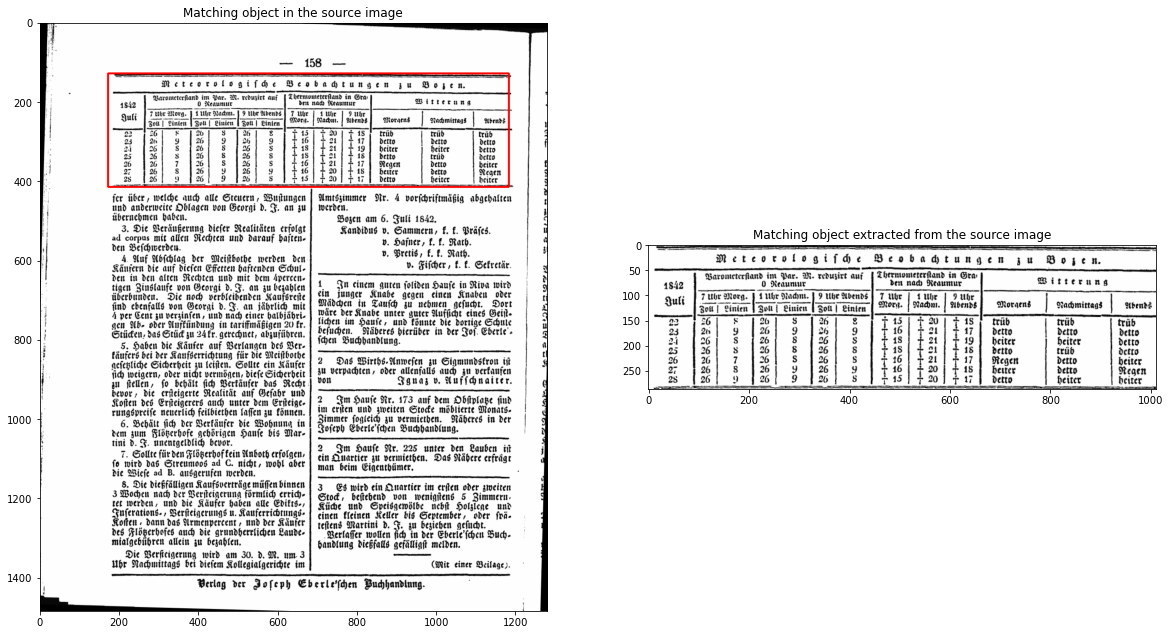

In [15]:
template_height = template.shape[0]
template_width = template.shape[1]
top_left_corner = max_loc_opt # <-- the optimal matching location
bottom_right_corner = (top_left_corner[0] + template_width, top_left_corner[1] + template_height)
img_rotated = imutils.rotate(img_rgb, -rotation_opt) # <-- the corrected source image rotation
img_rotated_copy = img_rotated.copy()
img_with_rectangle = cv2.rectangle(img_rotated, top_left_corner, bottom_right_corner, 255, 4)
cropped_matching_object = img_rotated_copy[top_left_corner[1] : top_left_corner[1] + \
                                           template_height, top_left_corner[0] : top_left_corner[0] + template_width]

plt.figure(figsize = (20,16))
plt.subplot(1,2,1)
plt.imshow(img_with_rectangle)
plt.title("Matching object in the source image")
plt.subplot(1,2,2)
plt.imshow(cropped_matching_object)
plt.title("Matching object extracted from the source image")
plt.show()

## Customization Options

Aspects of the matching procedure can be customized. Instead of using the minMaxLoc()-function in order to find the optimal matching location between source image and template, one could iteratively search for it. This is demonstrated by the code below, which is included with minimal comment. 

In [16]:
# find best matching subpicture
def find_picture_match(img_rgb, template, init_thrs, step, loc, w, h):
    
    # img_rgb, template: source image, template
    # init_thrs: initial threshold for the values of the matching array
    # step: iteration steps
    # loc: matching location
    # w, h: template width and height
    
    thrs = init_thrs
    n_loc = len(loc[0]) 
    while (thrs < 1.0 and n_loc > 0):
        res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
        threshold = thrs
        old_loc = loc
        loc = np.where(res >= threshold)
        n_loc = len(loc[0])
        thrs += step
        if n_loc < 1:
            loc = old_loc
    return loc, thrs-step
    # returns matching location and adapted threshold

In [17]:
# find best matching rotation
def find_rotation_match(img_rgb, template, init_rot, end_rot, rot_step, thrs):
    
    # img_rgb, template: source image, template
    # init_rot: first rotation angle
    # end_rot: last rotation angle
    # rot_step: rotation step
    # loc: matching location
    # thrs: threshold for the values of the matching array
    
    rotation = init_rot-rot_step
    n_loc = 0
    n_arr = []
    while (rotation <= end_rot):
        rotation += rot_step
        rotated = imutils.rotate(template, rotation)
        res = cv2.matchTemplate(img_rgb, rotated, cv2.TM_CCOEFF_NORMED)
        loc = np.where(res >= thrs)
        n_loc = len(loc[0])
        n_arr.append(n_loc)
    np_n_arr = np.array(n_arr)
    if np.max(n_arr) == 0:
        print("no matches found upon rotation")
        rotation = 0.0
    else:
        rotation = init_rot + (np.argmax(np_n_arr)*rot_step)
    return rotation
    # returns rotation angle

In [18]:
# initialize variables
init_thrs = 0.07 # initial threshold
step = 0.03 # step for increasing threshold
w, h = template.shape[:-1]
init_rot = -2.0 # initial rotation angle
end_rot = 2.0 # final rotation angle
rot_step = 0.02 # rotation step
tol = 0.01 # 1% extra border on each side
w_border = int(w*tol)
h_border = int(h*tol)

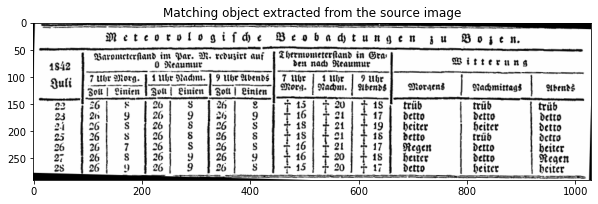

In [19]:
img_rgb = cv2.imread(document)
res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
loc = np.where(res >= init_thrs)
n_loc = len(loc[0])

location, threshold = find_picture_match(img_rgb, template, init_thrs, step, loc, w, h)

if threshold < 0.8: 
    old_location = location
    thrs = threshold 
    rotation = find_rotation_match(img_rgb, template, init_rot, end_rot, rot_step, thrs)
    rotated = imutils.rotate(template, rotation) # invert angle for rotating image
    res = cv2.matchTemplate(img_rgb, rotated, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= thrs)
    n_loc = len(loc[0])
    location, threshold = find_picture_match(img_rgb, rotated, thrs, step, loc, w, h)
    image = (location[::-1]) # <-- finds the best matching locations
    if len(image[0]) == 0:
        location = old_location
        image = (location[::-1])
    crop_img = img_rgb[int(image[1][0]-w_border):int(image[1][0]+w+w_border), int(image[0][0]-h_border):int(image[0][0]+h+h_border)]
    rot_crop_img = imutils.rotate(crop_img, -rotation) # invert rotation for result (rotation applies to template)
    plt.figure(figsize = (10,10))
    plt.imshow(rot_crop_img)
    plt.title("Matching object extracted from the source image")
    plt.show()      
else:
    image = (location[::-1])
    border = int(min(w, h)*tol)
    crop_img = img_rgb[int(image[1][0]-w_border):int(image[1][0]+w+w_border), int(image[0][0]-h_border):int(image[0][0]+h+h_border)]
    plt.figure(figsize = (10,10))
    plt.imshow(rot_crop_img)
    plt.title("Matching object extracted from the source image")
    plt.show() 